# Rob's sandbox

---

# Imports

#### Python modules

In [18]:
import sys

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import (
    train_test_split,
    cross_val_score
)
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

import pandas as pd
pd.set_option("display.max_columns", 50)

# Ancillary modules

#### Support adjustments

In [19]:
sys.path.append("../..")

#### Modules

In [20]:
%load_ext autoreload
%autoreload 2

from src.utils.data_dict import (
    data_dict
)

from src.utils.utils import (
    json_dump_dict,
    load_df
)

from src.utils.params import (
#     param_grid,
#     max_features,
#     n_estimators,
    evaluation_metric,
    feature_importance_theshold,
    tag_non_relevant_cats,
    ingestion_pickle_loc,
    transformation_pickle_loc,
    models_pickle_loc,
    X_train_pickle_loc,
    y_train_pickle_loc,
    X_test_pickle_loc,
    y_test_pickle_loc,
    test_predict_labs_pickle_loc,
    test_predict_scores_pickle_loc,
)

from src.pipelines.ingestion import (
    ingest
)

from src.pipelines.transformation import (
    load_ingestion,
#     date_transformation,
#     hour_transformation,
#     categoric_trasformation,
    transform
)

from src.pipelines.feature_engineering import (
    load_transformation,
    feature_generation,
    feature_selection,
    save_fe,
    feature_engineering,
    fe_pickle_loc_imp_features,
    fe_pickle_loc_feature_labs
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

# Original data

In [ ]:
df_o = pd.read_csv("../../" + "data/incidentes-viales-c5.csv")
df_o

# Tests

## Transformation

#### Loading ingestion pickle

In [ ]:
df_ing = load_ingestion("../../" + ingestion_pickle_loc)

In [ ]:
df_ing

In [ ]:
df_ing["label"].value_counts(normalize=True)

## Feature engineering

#### Loading transformation pickles

In [ ]:
df_tra = load_transformation("../../" + transformation_pickle_loc)
df_tra

##### Exploring transfomation result

#### Processing data for model

In [ ]:
df_features_prc, df_labels, df_features_prc_cols = feature_generation(df)

In [ ]:
print(len(df_features_prc_cols))
df_features_prc_cols

In [ ]:
df_features_prc.shape

In [ ]:
print(len(enc_cat_features))
enc_cat_features

In [ ]:
df_features_prc.shape

In [ ]:
len(df_features_prc_cols)

#### Training, executing and evaluating model

In [ ]:
model = RandomForestClassifier(oob_score=True, n_jobs=-1)

In [ ]:
## Splitting data in train and test
X_train, X_test, y_train, y_test = train_test_split(df_features_prc, df_labels, test_size=0.3)

In [ ]:
grid_search = GridSearchCV(model,
                           param_grid,
                           cv=2,
                           scoring=evaluation_metric,
                           return_train_score=True,
                           n_jobs=-1
                           )

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_estimator_)

print("\n++ Grid search results:\n")
print("    ++++ Best estimator: {}".format(grid_search.best_estimator_))
print("    ++++ Number of features in best estimator: {} \n".format(grid_search.best_estimator_.n_features_))
print("    ++++ Best estimator oob score: {}\n".format(grid_search.best_estimator_.oob_score_))

#### Identifying most important variables

##### Creating dataframe with ranks

##### Obtaining features cleaning dict from ranked features

In [ ]:
feature_importance.reset_index(inplace=True, drop=True)
feature_importance

In [ ]:
feature_importance["Important"] = feature_importance["Importance"].apply(lambda x: True if x >= feature_importance_theshold else False)

In [ ]:
def find_mother(row, ohe_dict):
    """
    """
    
    for key in ohe_dict:
        if row in ohe_dict[key]:
            return key
    
    return row

In [ ]:
feature_importance["Mother_feature"] = feature_importance["Feature"].apply(lambda x: find_mother(x, ohe_dict))

In [ ]:
feature_importance

In [ ]:
def feature_cleaning_dict(feature_importance, ohe_dict):
    
    m1 = feature_importance["Important"] == True
    important_features = list(feature_importance.loc[m1, "Mother_feature"].unique())

    fe_cln_dict = {}

    for imp_f in important_features:

        m2 = feature_importance["Mother_feature"] == imp_f

        if imp_f in ohe_dict:
            fe_cln_dict[imp_f] = {
                "data_type": "categoric",
                "important_categories": list(feature_importance.loc[(m1 & m2), "Feature"])
            }
        else:
            fe_cln_dict[imp_f] = {
                "data_type": "non-categoric",
            }

#     json_dump_dict(fe_cln_dict)
    
    return fe_cln_dict

In [ ]:
fe_cln_dict = feature_cleaning_dict(feature_importance, ohe_dict)
fe_cln_dict

##### Cleaning transformation dataframe based on features cleaning dict

In [ ]:
df_tra

In [ ]:
nr_f = [col for col in df_tra.columns if col not in fe_cln_dict]
df_tra.drop(nr_f, axis=1, inplace=True)

In [ ]:
df_tra

In [ ]:
for cat_key in [key for key in fe_cln_dict if fe_cln_dict[key]["data_type"] == "categoric"]:
    m1 = ~df_tra[cat_key].isin(fe_cln_dict[cat_key]["important_categories"])
    df_tra.loc[m1, cat_key] = tag_non_relevant_cats

In [ ]:
df_tra

#### Reviewing results

In [ ]:
df_imp_features_prc = load_df("../../" + fe_pickle_loc_imp_features)
df_labels = load_df("../../" + fe_pickle_loc_feature_labs)

In [ ]:
print(df_imp_features_prc.shape)
df_imp_features_prc.toarray()

In [ ]:
print(df_labels.shape)
df_labels

## Modeling (magic loop)

### Imports and reviewing results

In [21]:
best_model = load_df("../../" + models_pickle_loc)
X_train = load_df("../../" + X_train_pickle_loc)
y_train = load_df("../../" + y_train_pickle_loc)
X_test = load_df("../../" + X_test_pickle_loc)
y_test = load_df("../../" + y_test_pickle_loc)
test_predict_labs = load_df("../../" + test_predict_labs_pickle_loc)
test_predict_scores = load_df("../../" + test_predict_scores_pickle_loc)

In [22]:
best_model

RandomForestClassifier(max_features=6, max_leaf_nodes=10, min_samples_leaf=3,
                       n_jobs=-1, oob_score=True, random_state=1111)

In [23]:
print(X_train.shape)
X_train.toarray()

(968196, 22)


array([[ 0.        ,  1.        ,  0.        , ...,  1.        ,
        -0.34585266,  1.38026149],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
        -0.8966045 , -0.5963419 ],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
        -0.65748251, -0.89602004],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -1.04692287, -0.2473593 ],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.7959287 , -1.2705245 ],
       [ 0.        ,  1.        ,  0.        , ...,  1.        ,
         0.01704798,  1.52481481]])

In [24]:
print(y_train.shape)
print(y_train.value_counts(normalize=True))
y_train

(968196,)
0.0    0.795937
1.0    0.204063
Name: label, dtype: float64


folio
C5/200205/08118    1.0
C5/180607/06491    0.0
C5/170109/03204    0.0
C5/170530/03787    0.0
C5/190412/07564    0.0
                  ... 
C5/190105/02070    0.0
C4/160114/04450    1.0
C5/190202/07087    0.0
C5/160908/02000    1.0
C5/201010/08534    0.0
Name: label, Length: 968196, dtype: float64

In [25]:
print(X_test.shape)
X_test.toarray()

(414942, 22)


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.8966045 ,  0.85063221],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.40648834, -1.31982895],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         1.91117035,  0.12714516],
       ...,
       [ 0.        ,  1.        ,  0.        , ...,  1.        ,
        -0.65748251, -0.89602004],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
        -0.65748251,  1.15031035],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
        -1.04692287, -0.2473593 ]])

In [26]:
print(y_test.shape)
print(y_test.value_counts(normalize=True))
y_test

(414942,)
0.0    0.795803
1.0    0.204197
Name: label, dtype: float64


folio
C5/190613/06795    0.0
C4/150322/02894    0.0
C5/180302/01135    0.0
C5/190411/07684    0.0
C5/170212/06529    0.0
                  ... 
C4/140505/00861    0.0
C5/190118/07088    0.0
C5/200814/04440    0.0
C5/170218/07803    0.0
AO/190428/07143    0.0
Name: label, Length: 414942, dtype: float64

In [27]:
print(test_predict_labs.shape)
print("Suma: ", sum(test_predict_labs))
test_predict_labs

(414942,)
Suma:  0.0


array([0., 0., 0., ..., 0., 0., 0.])

In [28]:
print(test_predict_scores.shape)
test_predict_scores

(414942, 2)


array([[0.85048844, 0.14951156],
       [0.71819398, 0.28180602],
       [0.70263902, 0.29736098],
       ...,
       [0.70665025, 0.29334975],
       [0.85405584, 0.14594416],
       [0.9267244 , 0.0732756 ]])

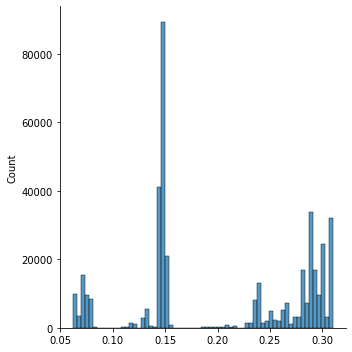

In [29]:
sns.displot(
    test_predict_scores[:, 1], 
)

### Fixing labels with predict scores

In [30]:
dfx = pd.DataFrame(y_test)
dfx["1_prob"] = test_predict_scores[:, 1]
dfx["prob_label"] = dfx["1_prob"].apply(lambda x: 1 if x <= 0.18 else 0)
dfx["correct"] = dfx.apply(lambda x: True if x["label"] == x["prob_label"] else False, axis=1)
dfx

,label,1_prob,prob_label,correct
folio,,,,
C5/190613/06795,0.0,0.149512,1,False
C4/150322/02894,0.0,0.281806,0,True
C5/180302/01135,0.0,0.297361,0,True
C5/190411/07684,0.0,0.146666,1,False
C5/170212/06529,0.0,0.309855,0,True
...,...,...,...,...
C4/140505/00861,0.0,0.133383,1,False
C5/190118/07088,0.0,0.146666,1,False
C5/200814/04440,0.0,0.293350,0,True


<AxesSubplot:xlabel='label', ylabel='1_prob'>

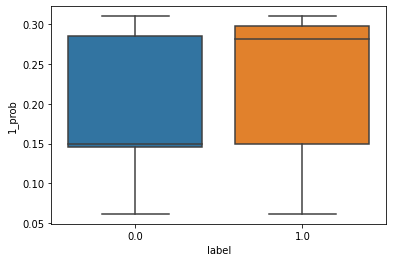

In [31]:
sns.boxplot(
    x=dfx["label"],
    y=dfx["1_prob"]
)

<AxesSubplot:xlabel='1_prob', ylabel='Density'>

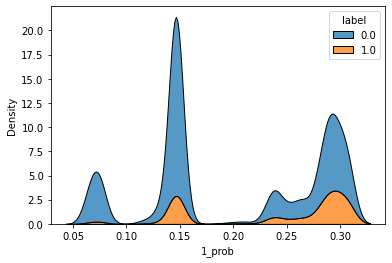

In [32]:
sns.kdeplot(
    data=dfx.loc[:, ["label", "1_prob"]],
    x="1_prob",
    hue="label",
    multiple="stack"
)

In [33]:
dfx["correct"].value_counts(normalize=True)

False    0.58726
True     0.41274
Name: correct, dtype: float64

In [34]:
confusion_matrix(dfx["label"], dfx["prob_label"])

array([[145153, 185059],
       [ 58620,  26110]])

# *Notes*

## Finding labels of processed matrix

#### Manually number of labels that should be in the model.

In [ ]:
cat_list = list(df_tra["dia_semana"].unique()) + \
            list(df_tra["incidente_c4"].unique()) + \
            list(df_tra["tipo_entrada"].unique()) + \
            list(df_tra["anio_inicio"].unique())

In [ ]:
print(len(cat_list))
cat_list

#### Example code from StackOverflow to get labels.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import _VectorizerMixin
from sklearn.feature_selection._base import SelectorMixin
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

train = pd.DataFrame({'age': [23,12, 12, np.nan],
                      'Gender': ['M','F', np.nan, 'F'],
                      'income': ['high','low','low','medium'],
                      'sales': [10000, 100020, 110000, 100],
                      'foo' : [1,0,0,1],
                      'text': ['I will test this',
                               'need to write more sentence',
                               'want to keep it simple',
                               'hope you got that these sentences are junk'],
                      'y': [0,1,1,1]})
numeric_columns = ['age']
cat_columns     = ['Gender','income']

numeric_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
cat_pipeline     = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())
text_pipeline = make_pipeline(CountVectorizer(), SelectKBest(k=5))

transformers = [
('num', numeric_pipeline, numeric_columns),
('cat', cat_pipeline, cat_columns),
('text', text_pipeline, 'text'),
('simple_transformer', MinMaxScaler(), ['sales']),
]

combined_pipe = ColumnTransformer(transformers, remainder='passthrough')

transformed_data = combined_pipe.fit_transform(train.drop('y',1), train['y'])

In [ ]:
train

In [ ]:
transformed_data.shape

In [ ]:
def get_feature_out(estimator, feature_in):
    if hasattr(estimator,'get_feature_names'):
        if isinstance(estimator, _VectorizerMixin):
            # handling all vectorizers
            return [f'vec_{f}' \
                for f in estimator.get_feature_names()]
        else:
            return estimator.get_feature_names(feature_in)
    elif isinstance(estimator, SelectorMixin):
        return np.array(feature_in)[estimator.get_support()]
    else:
        return feature_in


def get_ct_feature_names(ct):
    # handles all estimators, pipelines inside ColumnTransfomer
    # doesn't work when remainder =='passthrough'
    # which requires the input column names.
    output_features = []

    for name, estimator, features in ct.transformers_:
        if name!='remainder':
            if isinstance(estimator, Pipeline):
                current_features = features
                for step in estimator:
                    current_features = get_feature_out(step, current_features)
                features_out = current_features
            else:
                features_out = get_feature_out(estimator, features)
            output_features.extend(features_out)
        elif estimator=='passthrough':
            output_features.extend(ct._feature_names_in[features])
                
    return output_features




pd.DataFrame(transformed_data, 
             columns=get_ct_feature_names(combined_pipe))

In [ ]:
train

## Updating dictionary

In [ ]:
x_dict = {}

In [ ]:
var = "var_1"

In [ ]:
def create_datadict_entry(var, relevant=True, data_type="not_specified", model_relevant="False"):
    
    entry = {
        var: {
            "relevant": relevant,
            "data_type": data_type,
            "model_relevant": model_relevant
        }
    }
    
    x_dict.update(entry)
    
    return

In [ ]:
create_datadict_entry(var)

In [ ]:
x_dict

---
---